# Cuisine Classifier

@Noah Meißner 01.06.2025

Source Dataset: https://www.kaggle.com/datasets/kaggle/recipe-ingredients-dataset?resource=download

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import joblib  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm

import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()  # aktiviert tqdm-Integration für Pandas
from foodrec.config.structure.dataset_enum import DatasetEnum
from foodrec.utils.data_preperation.embedder import Embedder
from foodrec.tools.ingredient_normalizer_beta import IngredientNormalisation

## Download and Import Dataset

Due to the Data structure we can use only the Training Set, because the test set does not include the cuisine

In [2]:
path = kagglehub.dataset_download("kaggle/recipe-ingredients-dataset")
train_path = path +"/train.json"
train_data = pd.read_json(train_path)

## Helper Methods

In [3]:
regions = {
    "central_europe": ["british", "french", "greek", "irish", "italian", "russian", "spanish"],
    "north_america": ["cajun_creole", "southern_us", ],
    "asia": ["chinese", "filipino", "indian", "japanese", "korean", "thai", "vietnamese"],
    "middle_east": ["moroccan"],
    "latin_america": ["mexican", "jamaican", "brazilian"]
}

cuisine_to_region = {cuisine: region for region, cuisines in regions.items() for cuisine in cuisines}


In [5]:
def ingredients_to_text_single(ingredients, embedder,Normalize_embedder,  cache, vec=False, normalize = True):
    exclude = {'salt', 'onions', 'olive oil','pepper','oil', 'sugar', 'water'}
    filtered_ingredients = []

    for ing in ingredients:
        ing_lower = ing.lower()
        if ing_lower in exclude: 
            continue

        # Check cache
        if ing_lower in cache:
            embedding_result = cache[ing_lower]
        else:
            if normalize: 
                embedding_result = embedder.normalize(ing, 1)[0]
            else:
                embedding_result = Normalize_embedder.advanced_normalize(ing)
            try:
                if len(embedding_result) == 1:
                    print(ing, embedder.normalize(ing, 1), embedding_result)
                cache[ing_lower] = embedding_result
            except:
                print(embedding_result)

        filtered_ingredients.append(embedding_result)

    random.shuffle(filtered_ingredients)
    if vec:
        return filtered_ingredients
    return " ".join(filtered_ingredients)


## Exploratory Analysis

We want to check how different the ingredients in the Dataset are and how we are able to compare it
- Oriented on the following Analysis: https://www.kaggle.com/code/suraj5424/cuisine-prediction-semantic-solution

In [6]:
cuisine_to_region = {cuisine: region for region, cuisines in regions.items() for cuisine in cuisines}
raw_ingredients = train_data['ingredients']
flat = [item for sublist in raw_ingredients for item in sublist]
unique_ingredients = list(set(flat))
train_data['regions'] = train_data['cuisine'].map(cuisine_to_region)

In [7]:
train_data.head()
print(f"Dataset Length: {len(raw_ingredients)}")
print(f"Unique Ingredients: {len(unique_ingredients)}")


Dataset Length: 39774
Unique Ingredients: 6714


In [10]:
from collections import Counter
counter = Counter(train_data["cuisine"])
print(counter)

Counter({'italian': 7838, 'mexican': 6438, 'southern_us': 4320, 'indian': 3003, 'chinese': 2673, 'french': 2646, 'cajun_creole': 1546, 'thai': 1539, 'japanese': 1423, 'greek': 1175, 'spanish': 989, 'korean': 830, 'vietnamese': 825, 'moroccan': 821, 'british': 804, 'filipino': 755, 'irish': 667, 'jamaican': 526, 'russian': 489, 'brazilian': 467})


In [9]:
from collections import Counter
counter = Counter(train_data["regions"])
print(counter)

Counter({'central_europe': 14608, 'asia': 11048, 'latin_america': 7431, 'north_america': 5866, 'middle_east': 821})


### Distribution of Cuisines

/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_30250/1341319982.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cuisine', data=train_data, palette='viridis')


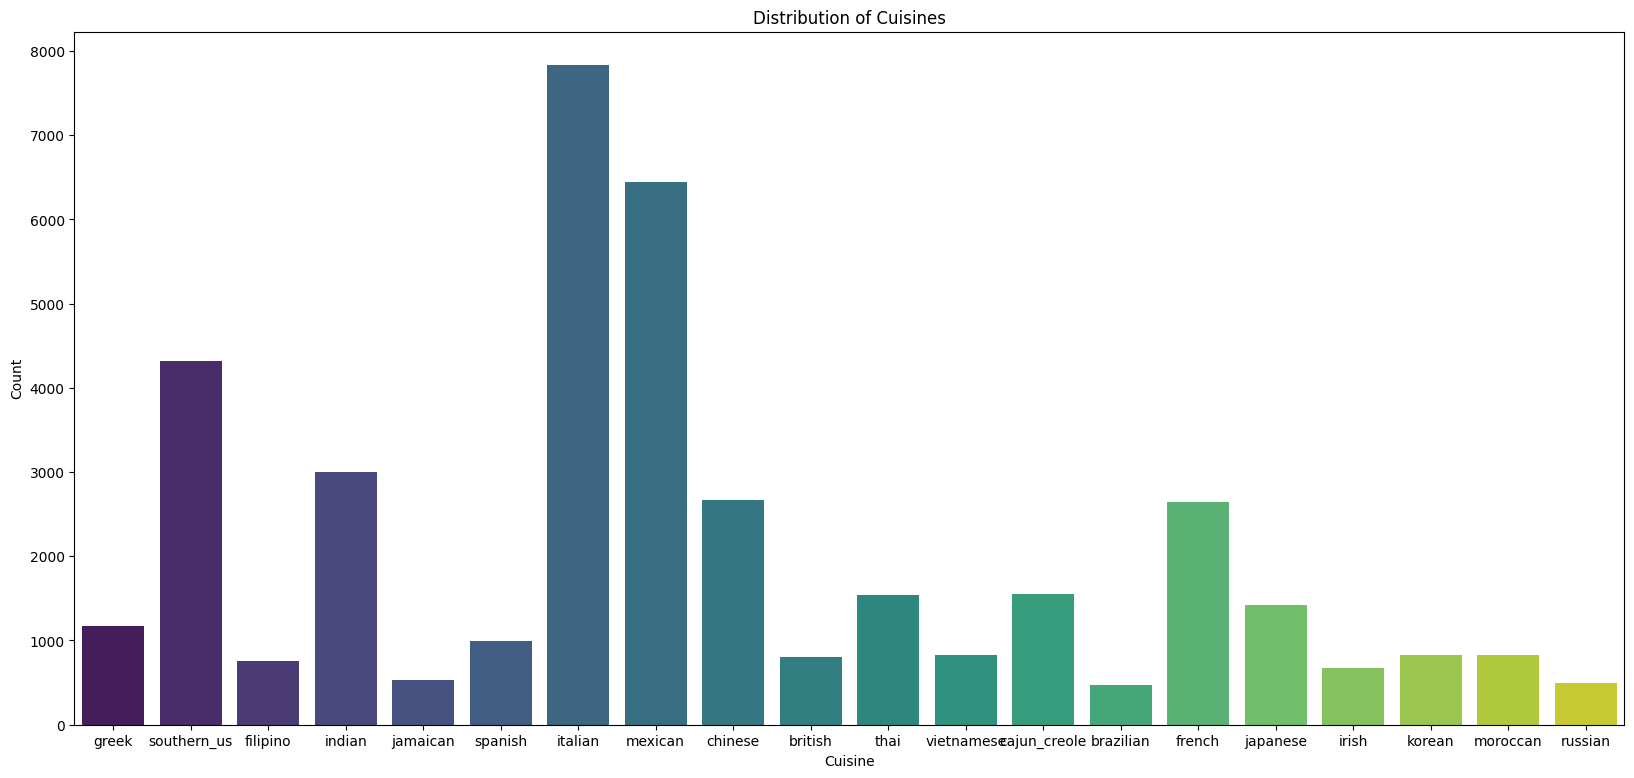

In [11]:
plt.figure(figsize=(20, 9))
sns.countplot(x='cuisine', data=train_data, palette='viridis')
plt.title('Distribution of Cuisines')
plt.xlabel('Cuisine')
plt.ylabel('Count')
plt.show()

### Distribution of Regions

/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_30250/1300143580.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='regions', data=train_data, palette='viridis')


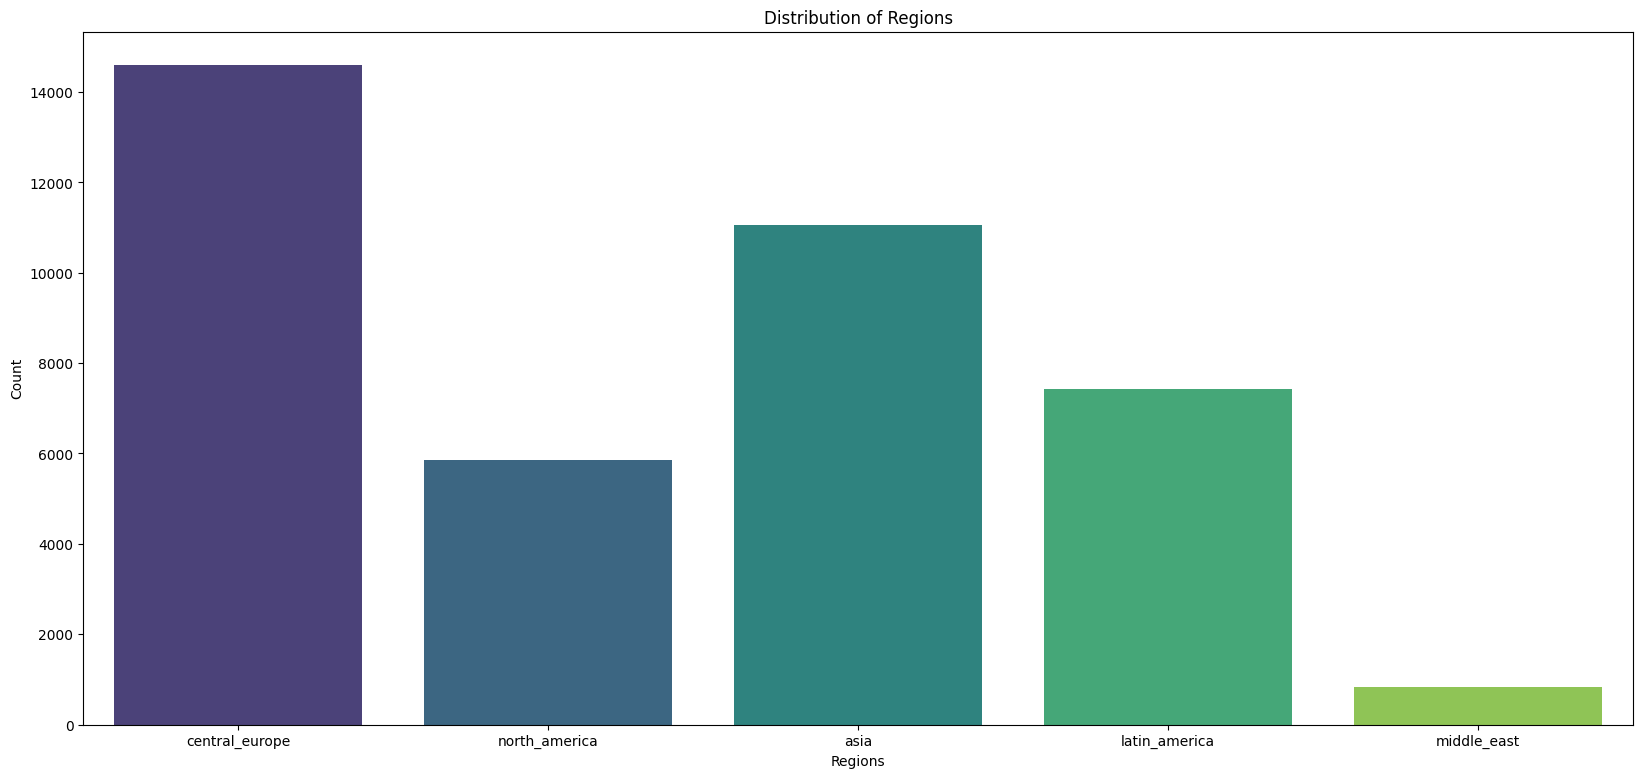

In [12]:
plt.figure(figsize=(20, 9))
sns.countplot(x='regions', data=train_data, palette='viridis')
plt.title('Distribution of Regions')
plt.xlabel('Regions')
plt.ylabel('Count')
plt.show()

### Number of Ingredients per Region

/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_30250/909845790.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='regions', y=train_data['ingredients'].apply(len), data=train_data, palette='Set3')


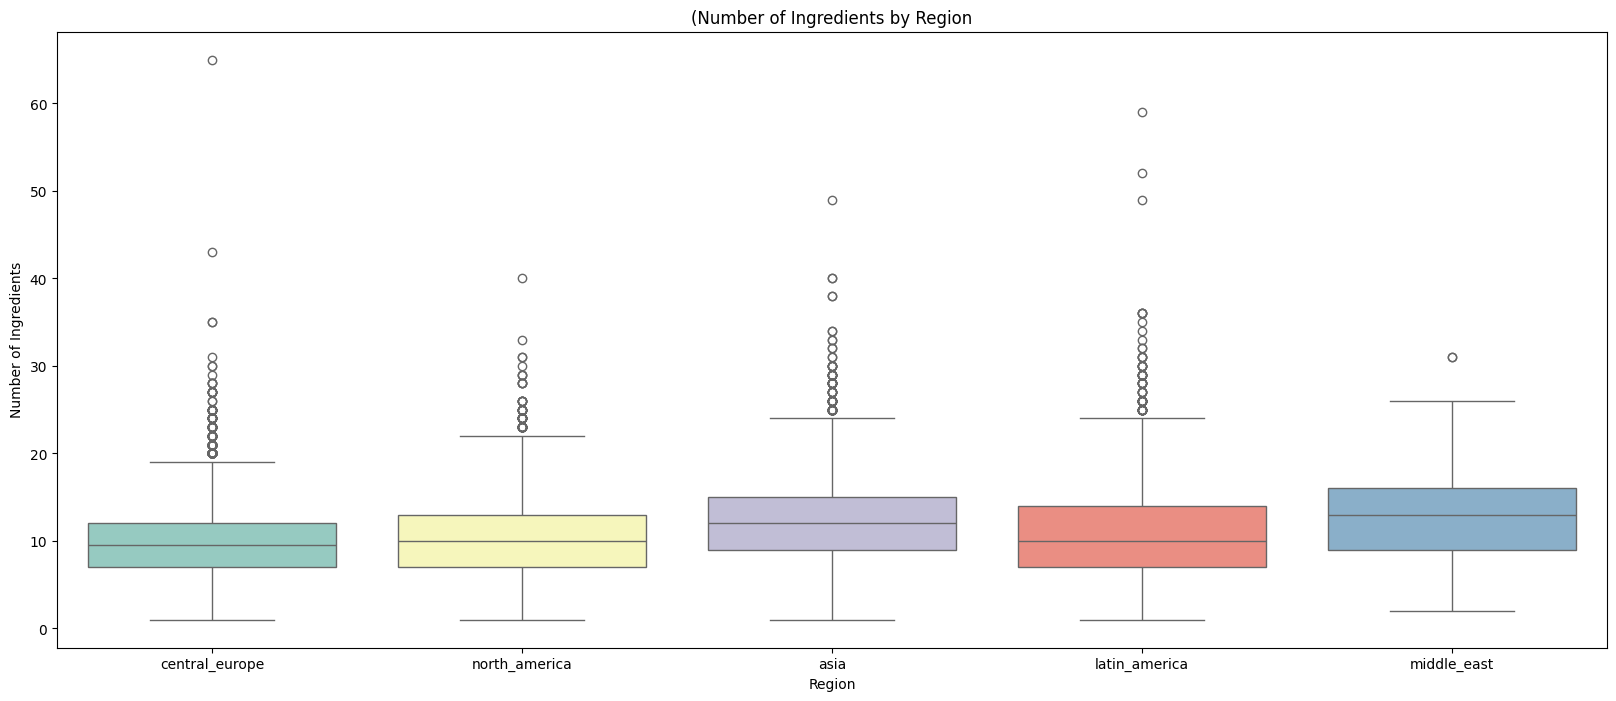

In [13]:
plt.figure(figsize=(20,8))
sns.boxplot(x='regions', y=train_data['ingredients'].apply(len), data=train_data, palette='Set3')
plt.title('(Number of Ingredients by Region')
plt.xlabel('Region')
plt.ylabel('Number of Ingredients')
plt.show()

### Top 20 Ingredients

/var/folders/6n/knlq_sss74g85w6tq1mnlfk40000gn/T/ipykernel_30250/2843211372.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='ingredient', data=ingredient_counts.head(20), palette='viridis')


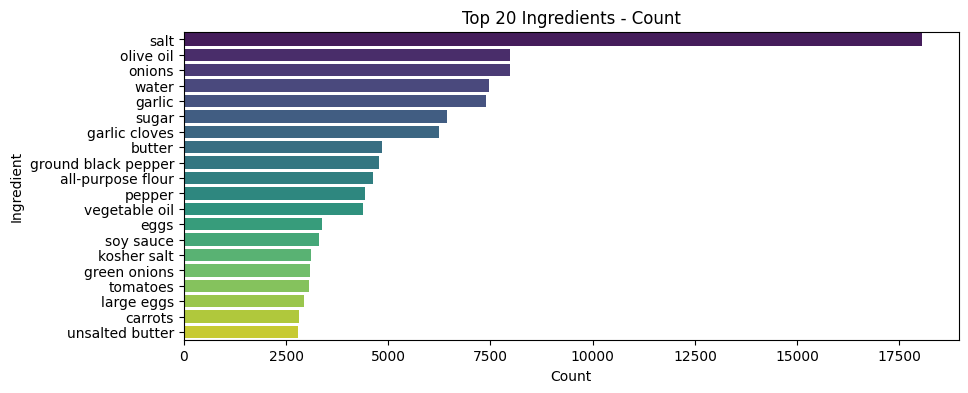

In [14]:
all_ingredients = [ingredient for ingredients_list in raw_ingredients for ingredient in ingredients_list]
ingredient_counts = pd.Series(all_ingredients).value_counts().reset_index()
ingredient_counts.columns = ['ingredient', 'count']
# Plot the count of ingredients
plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='ingredient', data=ingredient_counts.head(20), palette='viridis')
plt.title('Top 20 Ingredients - Count')
plt.xlabel('Count')
plt.ylabel('Ingredient')
plt.show()


## Training

In [15]:
embedder = IngredientNormalisation(DatasetEnum.ALL_RECIPE)
Normalize_embedder = Embedder()
embedding_cache = {}
raw_ingredients = train_data['ingredients']
train_data['ingredients_idf'] = train_data['ingredients']
train_data['ingredients_str'] = train_data['ingredients']
train_data['ingredients_idf'] = train_data['ingredients_idf'].progress_map(lambda x: ingredients_to_text_single(x, embedder,Normalize_embedder=None, cache=embedding_cache, vec=True))
train_data['ingredients_str'] = train_data['ingredients_str'].progress_map(lambda x: ingredients_to_text_single(x, embedder, Normalize_embedder=None, cache=embedding_cache))

2025-09-22 19:44:16,314 - foodrec.data.load_ingredient_embeddings - INFO - EmbeddingLoader initialized with path: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_ALL_RECIPE.csv
2025-09-22 19:44:16,315 - foodrec.data.load_ingredient_embeddings - INFO - Starting embedding retrieval process...
2025-09-22 19:44:16,316 - foodrec.data.load_ingredient_embeddings - INFO - ✓ Found existing embeddings file: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_ALL_RECIPE.csv
2025-09-22 19:44:16,316 - foodrec.data.load_ingredient_embeddings - INFO - Loading existing embeddings...


####################Load Embeddings####################


100%|██████████| 39774/39774 [00:00<00:00, 258554.46it/s]


In [16]:
def get_train_test_data(cuisine:bool=False):
    X = train_data['id']# alle anderen Spalten außer 'region'
    y = train_data['regions']   
    if cuisine:
        y = train_data['cuisine']
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.1, random_state=42, stratify=y_temp
    )
    X_train_sparse = [
    train_data.loc[train_data['id']==data, 'ingredients_idf'].values[0] 
    for data in X_train
    ]
    X_val_sparse = [
    train_data.loc[train_data['id']==data, 'ingredients_idf'].values[0] 
    for data in X_val
    ]
    X_test_sparse = [
        train_data.loc[train_data['id']==data, 'ingredients_idf'].values[0] 
        for data in X_test
    ]
    x_train_dense = [
        train_data.loc[train_data['id']==data, 'ingredients_str'].values[0] 
        for data in X_test
    ]
    X_val_dense = [
    train_data.loc[train_data['id']==data, 'ingredients_str'].values[0] 
    for data in X_val
    ]
    X_test_dense = [
        train_data.loc[train_data['id']==data, 'ingredients_str'].values[0] 
        for data in X_test
    ]
    X_temp_sparse = [
        train_data.loc[train_data['id']==data, 'ingredients_idf'].values[0] 
        for data in X_temp
    ]

    X_temp_dense = [
        train_data.loc[train_data['id']==data, 'ingredients_str'].values[0] 
        for data in X_temp
    ]


    return X_temp_sparse, X_temp_dense,  y_temp, X_train_sparse,x_train_dense, y_train, X_val_sparse, y_val,X_val_dense, X_test_sparse,X_test_dense, y_test

In [17]:
X_temp_sparse_cuisine, X_temp_dense_cuisine, y_temp_cuisine, X_train_sparse_cuisine, x_train_dense_cuisine, y_train_cuisine, X_val_sparse_cuisine, y_val_cuisine, X_val_dense_cuisine, X_test_sparse_cuisine, X_test_dense_cuisine, y_test_cuisine = get_train_test_data(cuisine=True)
X_temp_sparse_region, X_temp_dense_region, y_temp_region, X_train_sparse_region, x_train_dense_region, y_train_region, X_val_sparse_region, y_val_region, X_val_dense_region, X_test_sparse_region, X_test_dense_region, y_test_region = get_train_test_data(cuisine=False)

## Model Training

### Dummy Classifier

In [18]:
def dummy_Classification(X_train, X_test, y_train, y_test):
    dummy = DummyClassifier(strategy="stratified", random_state=42)
    dummy.fit(X_train, y_train)
    y_pred = dummy.predict(X_test)
    report = classification_report(y_test, y_pred, zero_division=0)
    print(report)


### Logistic Regression

In [19]:
def tf_idf(X_train, X_test, y_train, y_test):
    X_train_str = [" ".join(tokens) for tokens in X_train]
    X_test_str  = [" ".join(tokens) for tokens in X_test]

    # Pipeline: TF-IDF Vektorisierung + Logistische Regression
    logreg_tfidf = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),      # Unigramme und Bigramme
            min_df=2,               # ignoriert seltene Wörter
            max_features=5000       # begrenzt Vokabulargröße
        )),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced", # wichtig bei Klassenungleichgewicht
            solver="liblinear"
        ))
    ])

    # Training
    logreg_tfidf.fit(X_train_str, y_train)
    joblib.dump(logreg_tfidf, "logreg_tfidf.pkl")

    # Evaluation
    y_pred = logreg_tfidf.predict(X_test_str)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

        # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=logreg_tfidf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_tfidf.classes_)

    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, values_format="d")
    plt.title("Confusion Matrix (TF-IDF + Logistic Regression)")
    plt.show()


In [20]:
def train_xgb_model(
    X, y, X_test, y_test,
    save: bool = False,
    shap_sample: int = 4000,
    shap_top_n: int = 20,
    shap_plots: bool = False,
    shap_model_output: str = None
):
    # 1) Labels einmalig fitten (nicht pro Fold neu!)
    label_encoder = LabelEncoder()
    y_enc = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)

    # 2) Pipeline: Vektorisierung + Modell zusammen halten
    base_clf = XGBClassifier(
        objective='multi:softprob',
        num_class=num_classes,
        random_state=42,
        n_jobs=-1,
    )
    pipe = Pipeline([
        ('vect', CountVectorizer()),
        ('clf',  base_clf),
    ])

    # 3) Cross-Validation (nur zur Bewertung)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_pred_cv = cross_val_predict(pipe, X, y_enc, cv=skf, method='predict')

    f1_macro = f1_score(y_enc, y_pred_cv, average='macro')
    f1_weighted = f1_score(y_enc, y_pred_cv, average='weighted')
    print(f"CV F1 (macro):    {f1_macro:.4f}")
    print(f"CV F1 (weighted): {f1_weighted:.4f}")
    print("\nCV Classification Report:")
    print(classification_report(y_enc, y_pred_cv, target_names=label_encoder.classes_))

    # 4) FINAL-TRAIN: jetzt die GLEICHE Pipeline auf ALLEN Trainingsdaten fitten
    pipe.fit(X, y_enc)

    # 5) Test-Set evaluieren
    #    y_test kann String-Labels enthalten: entweder encoden oder Predictions zurück-decodieren
    y_test_enc = label_encoder.transform(y_test)
    y_pred_test_enc = pipe.predict(X_test)

    test_acc = accuracy_score(y_test_enc, y_pred_test_enc)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_enc, y_pred_test_enc, target_names=label_encoder.classes_))

    # Konfusionsmatrix (mit Klassennamen anzeigen)
    labels = label_encoder.classes_
    cm = confusion_matrix(y_test_enc, y_pred_test_enc, labels=np.arange(num_classes))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title('Confusion Matrix - Test Set')
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout(); plt.show()

    # 6) Optional: speichern (Pipeline + LabelEncoder)
    if save:
        joblib.dump(pipe, "model/cuisine_pipeline.joblib")
        joblib.dump(label_encoder, "model/label_encoder.joblib")
        print("Finale Pipeline gespeichert unter model/…")

    # 7) (Optional) einfache globale Feature-Importance aus XGB (nach FINAL-TRAIN)
    def print_top_features_global(fitted_pipe, top_n=15):
        vect = fitted_pipe.named_steps['vect']
        clf  = fitted_pipe.named_steps['clf']
        feature_names = np.array(vect.get_feature_names_out())
        booster = clf.get_booster()
        scores = booster.get_score(importance_type="weight")
        idx_map = {int(k[1:]): v for k, v in scores.items() if k.startswith("f")}
        if not idx_map:
            print("\nKeine Feature-Importances verfügbar.")
            return
        total = sum(idx_map.values())
        norm_scores = {k: v / total for k, v in idx_map.items()}
        top_idx = sorted(idx_map, key=idx_map.get, reverse=True)[:top_n]
        print("\nTop Globale Features (importance_type='weight'):\n")
        for idx in top_idx:
            abs_val = idx_map[idx]
            rel_val = norm_scores[idx] * 100
            print(f"{feature_names[idx]:<20}  weight={abs_val:<5}  ({rel_val:5.2f}%)")

    print_top_features_global(pipe, top_n=15)

    return pipe, label_encoder


## Results

### Dummy Classification

#### Cuisines

In [21]:
dummy_Classification(X_train=X_temp_dense_cuisine, y_train=y_temp_cuisine, X_test=X_test_dense_cuisine,y_test=y_test_cuisine)

              precision    recall  f1-score   support

   brazilian       0.01      0.01      0.01        93
     british       0.01      0.01      0.01       161
cajun_creole       0.03      0.03      0.03       309
     chinese       0.08      0.07      0.07       535
    filipino       0.01      0.01      0.01       151
      french       0.08      0.08      0.08       529
       greek       0.03      0.03      0.03       235
      indian       0.07      0.07      0.07       601
       irish       0.01      0.01      0.01       133
     italian       0.20      0.20      0.20      1568
    jamaican       0.00      0.00      0.00       105
    japanese       0.02      0.01      0.01       284
      korean       0.03      0.03      0.03       166
     mexican       0.18      0.18      0.18      1288
    moroccan       0.01      0.01      0.01       164
     russian       0.00      0.00      0.00        98
 southern_us       0.11      0.11      0.11       864
     spanish       0.01    

#### Regions

In [22]:
dummy_Classification(X_train=X_temp_dense_region, y_train=y_temp_region, X_test=X_test_dense_region,y_test=y_test_region)

                precision    recall  f1-score   support

          asia       0.28      0.28      0.28      2210
central_europe       0.36      0.36      0.36      2922
 latin_america       0.19      0.19      0.19      1486
   middle_east       0.02      0.02      0.02       164
 north_america       0.14      0.14      0.14      1173

      accuracy                           0.27      7955
     macro avg       0.20      0.20      0.20      7955
  weighted avg       0.27      0.27      0.27      7955



### Logistic Regression

#### Cuisines

/Users/noah/Documents/github/MultiAgentBiase/system/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy: 0.7464487743557511
              precision    recall  f1-score   support

   brazilian       0.51      0.68      0.58        93
     british       0.38      0.48      0.42       161
cajun_creole       0.71      0.77      0.74       309
     chinese       0.82      0.81      0.81       535
    filipino       0.57      0.62      0.59       151
      french       0.55      0.60      0.57       529
       greek       0.69      0.74      0.72       235
      indian       0.88      0.89      0.88       601
       irish       0.43      0.53      0.48       133
     italian       0.87      0.77      0.81      1568
    jamaican       0.61      0.75      0.68       105
    japanese       0.75      0.68      0.71       284
      korean       0.73      0.78      0.75       166
     mexican       0.91      0.88      0.89      1288
    moroccan       0.69      0.79      0.74       164
     russian       0.38      0.61      0.47        98
 southern_us       0.76      0.68      0.72       86

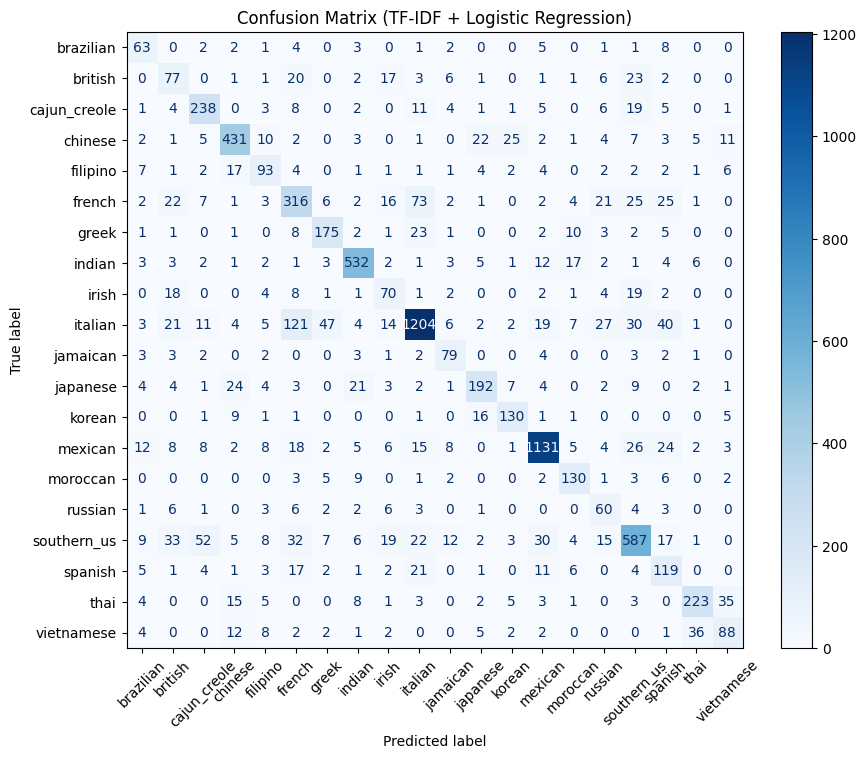

In [23]:
tf_idf(X_train=X_temp_sparse_cuisine, X_test=X_test_sparse_cuisine, y_train=y_temp_cuisine, y_test=y_test_cuisine)

#### Region

/Users/noah/Documents/github/MultiAgentBiase/system/myenv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1288: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Accuracy: 0.8856065367693274
                precision    recall  f1-score   support

          asia       0.94      0.92      0.93      2210
central_europe       0.89      0.90      0.89      2922
 latin_america       0.92      0.88      0.90      1486
   middle_east       0.70      0.83      0.76       164
 north_america       0.78      0.81      0.79      1173

      accuracy                           0.89      7955
     macro avg       0.84      0.87      0.85      7955
  weighted avg       0.89      0.89      0.89      7955



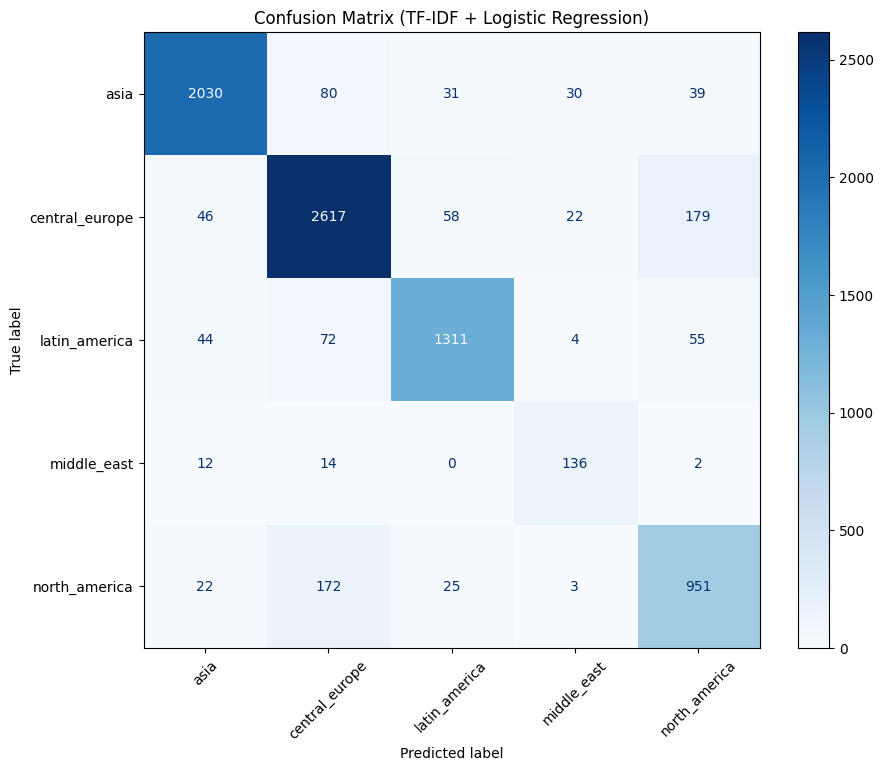

In [24]:
tf_idf(X_train=X_temp_sparse_region, X_test=X_test_sparse_region, y_train=y_temp_region, y_test=y_test_region)

### XGBClassifier

#### Cuisines

In [25]:
def map_to_region(pipe, label_encoder, x_test, y_test):
 y_test_mapped = [cuisine_to_region[c] for c in y_test]
 test_predictions = pipe.predict(x_test)
 test_pred_labels = label_encoder.inverse_transform(test_predictions)
 test_pred_labels_mapped = [cuisine_to_region[c] for c in test_pred_labels]
 class_report_test = classification_report(y_test_mapped, test_pred_labels_mapped)
 print("\nClassification Report (Test Set):") 
 print(class_report_test)
 cm = confusion_matrix(y_test_mapped, test_pred_labels_mapped, labels=sorted(set(y_test_mapped)))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test_mapped)))

    # Plotten
 fig, ax = plt.subplots(figsize=(6,6))
 disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
 plt.title("Confusion Matrix Map Cuisine to Region")
 plt.show()


CV F1 (macro):    0.6962
CV F1 (weighted): 0.7667

CV Classification Report:
              precision    recall  f1-score   support

   brazilian       0.77      0.55      0.64       374
     british       0.63      0.39      0.48       643
cajun_creole       0.79      0.70      0.74      1237
     chinese       0.76      0.83      0.80      2138
    filipino       0.71      0.56      0.62       604
      french       0.59      0.61      0.60      2117
       greek       0.79      0.69      0.74       940
      indian       0.85      0.90      0.87      2402
       irish       0.65      0.45      0.53       534
     italian       0.77      0.88      0.82      6270
    jamaican       0.85      0.67      0.75       421
    japanese       0.80      0.67      0.73      1139
      korean       0.84      0.73      0.78       664
     mexican       0.89      0.92      0.91      5150
    moroccan       0.83      0.71      0.77       657
     russian       0.64      0.41      0.50       391
 sou

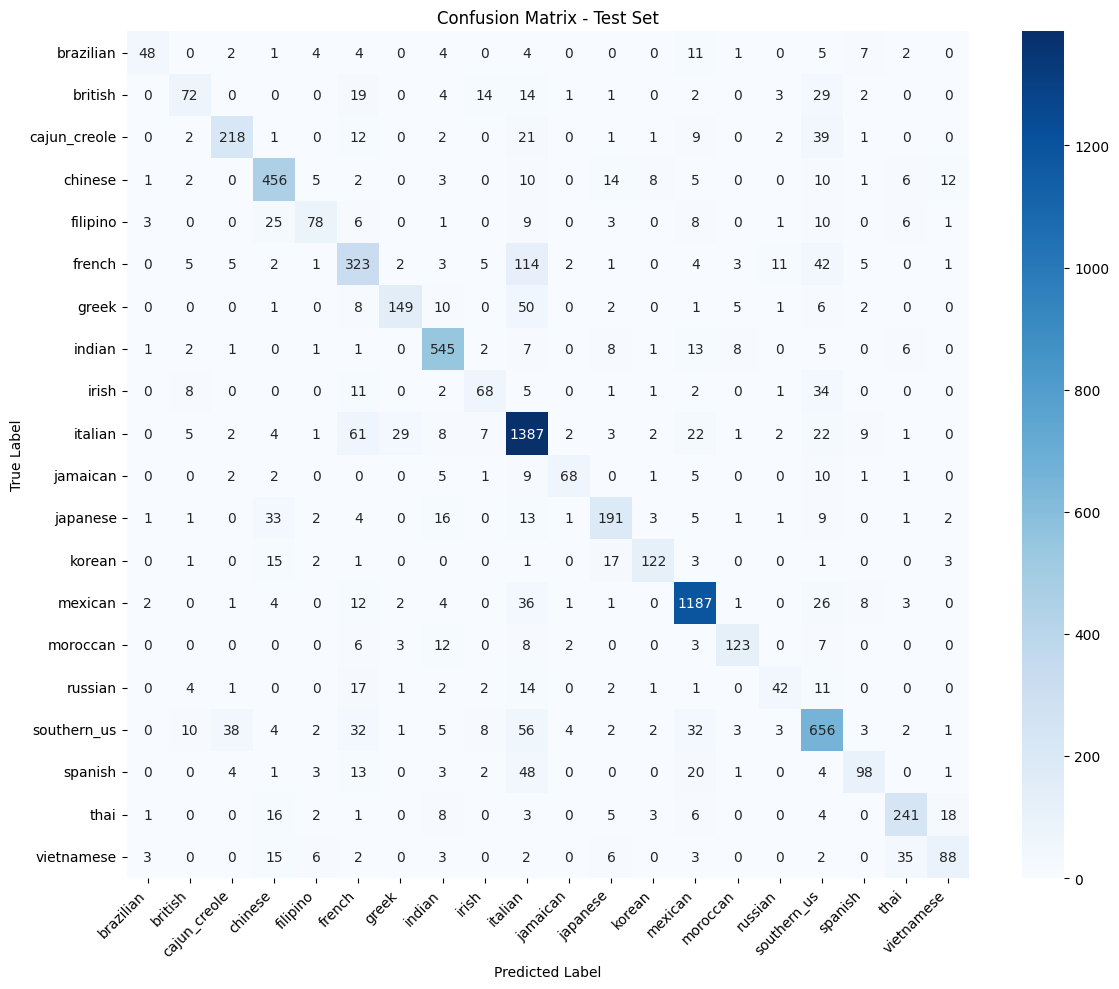

Finale Pipeline gespeichert unter model/…

Top Globale Features (importance_type='weight'):

pepper                weight=1027.0  ( 2.33%)
ground                weight=919.0  ( 2.08%)
garlic                weight=723.0  ( 1.64%)
egg                   weight=679.0  ( 1.54%)
oil                   weight=657.0  ( 1.49%)
fresh                 weight=623.0  ( 1.41%)
sauce                 weight=616.0  ( 1.40%)
tomato                weight=596.0  ( 1.35%)
chicken               weight=592.0  ( 1.34%)
butter                weight=524.0  ( 1.19%)
dried                 weight=524.0  ( 1.19%)
cheese                weight=520.0  ( 1.18%)
onion                 weight=502.0  ( 1.14%)
ginger                weight=501.0  ( 1.13%)
milk                  weight=494.0  ( 1.12%)


In [26]:
pipe, label_encoder = train_xgb_model(
	X_temp_dense_cuisine, y_temp_cuisine, X_test_dense_cuisine, y_test_cuisine, save=True, shap_model_output="raw"
)


Classification Report (Test Set):
                precision    recall  f1-score   support

          asia       0.94      0.92      0.93      2210
central_europe       0.89      0.90      0.90      2922
 latin_america       0.90      0.89      0.89      1486
   middle_east       0.84      0.76      0.80       164
 north_america       0.79      0.81      0.80      1173

      accuracy                           0.89      7955
     macro avg       0.87      0.86      0.86      7955
  weighted avg       0.89      0.89      0.89      7955



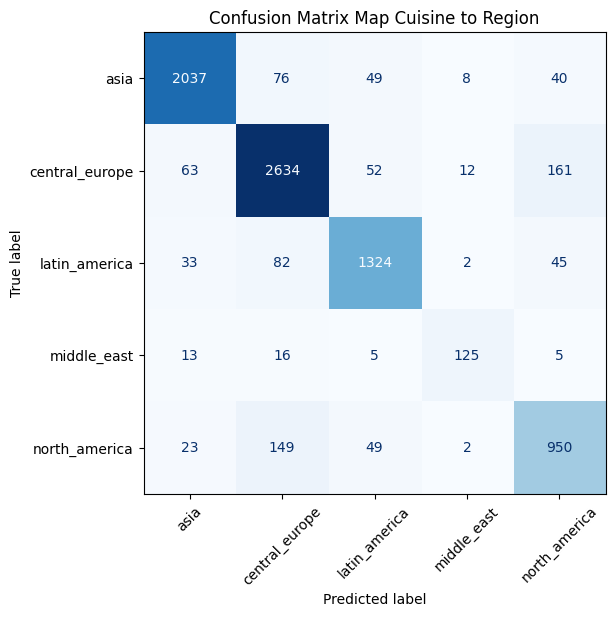

In [123]:
map_to_region(pipe, label_encoder, X_test_dense_cuisine, y_test_cuisine)

#### Regions

CV F1 (macro):    0.8549
CV F1 (weighted): 0.8841

CV Classification Report:
                precision    recall  f1-score   support

          asia       0.94      0.92      0.93      8838
central_europe       0.85      0.93      0.89     11686
 latin_america       0.91      0.86      0.88      5945
   middle_east       0.87      0.69      0.77       657
 north_america       0.85      0.76      0.80      4693

      accuracy                           0.89     31819
     macro avg       0.88      0.83      0.85     31819
  weighted avg       0.89      0.89      0.88     31819


Test Accuracy: 0.8890

Classification Report (Test Set):
                precision    recall  f1-score   support

          asia       0.94      0.92      0.93      2210
central_europe       0.85      0.93      0.89      2922
 latin_america       0.92      0.88      0.90      1486
   middle_east       0.87      0.73      0.79       164
 north_america       0.86      0.75      0.80      1173

      accuracy      

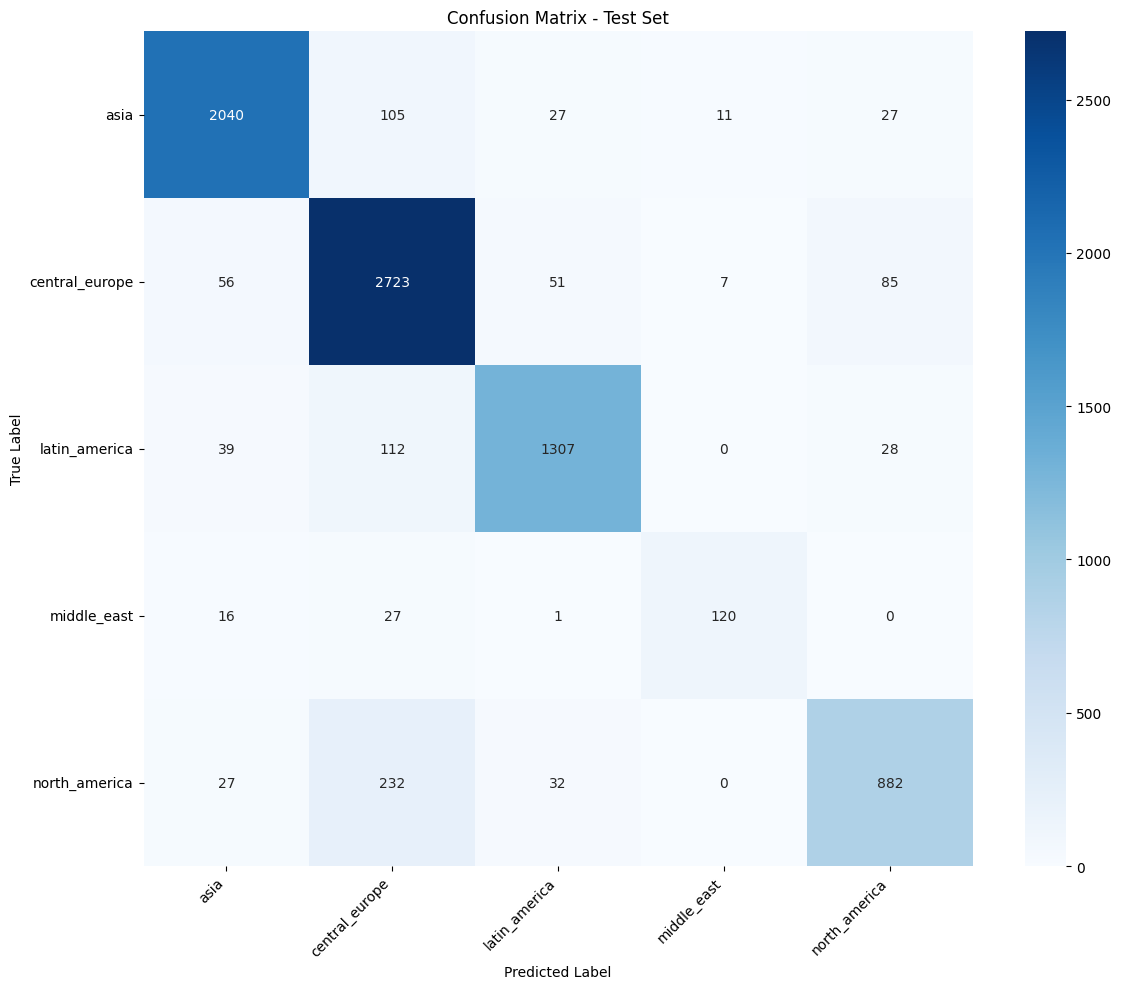

Finale Pipeline gespeichert unter model/…

Top Globale Features (importance_type='weight'):

pepper                weight=307.0  ( 2.43%)
ground                weight=288.0  ( 2.28%)
sauce                 weight=208.0  ( 1.64%)
egg                   weight=193.0  ( 1.53%)
cheese                weight=187.0  ( 1.48%)
garlic                weight=177.0  ( 1.40%)
powder                weight=164.0  ( 1.30%)
tomato                weight=163.0  ( 1.29%)
dried                 weight=157.0  ( 1.24%)
chicken               weight=148.0  ( 1.17%)
fresh                 weight=147.0  ( 1.16%)
green                 weight=143.0  ( 1.13%)
butter                weight=135.0  ( 1.07%)
cumin                 weight=133.0  ( 1.05%)
onion                 weight=129.0  ( 1.02%)


In [19]:
p, l = train_xgb_model(X_temp_dense_region, y_temp_region, X_test_dense_region, y_test_region, save=True, shap_model_output="raw")

## Analyse Cusisine Datasets

In [10]:
import pandas as pd
import numpy as np
from foodrec.config.structure.paths import DATASET_PATHS
from foodrec.data.all_recipe import AllRecipeLoader

In [14]:
AL_Loader = AllRecipeLoader()
df_all_recipe = AL_Loader.load_dataset()


In [15]:
df_all_recipe.head()

,recipe_href,recipe_name,description,rating_rate,ingredients_normalized,tutorial,cooking_time,protein,carbohydrates,fat,kcal
0,http://allrecipes.com/recipe/1-2-3-cheddar-bro...,1-2-3 Cheddar Broccoli Casserole,'Serve this casserole over hot baked potatoes ...,5.0,"['fig spread', 'broccoli floret', 'cheddar che...",Preheat oven to 350 degrees F. Combine Double ...,25.0,3.16087,6.37818,6.94262,97
3,http://allrecipes.com/recipe/1-2-3-chicken-cac...,1-2-3 Chicken Cacciatore,"'For this tasty and easy cacciatore, chicken i...",3.0,"['olive oil', 'chicken leg', 'pasta sauce']",Heat oil in 12-inch skillet over medium-high h...,60.0,10.22730,4.48565,5.41866,109
5,http://allrecipes.com/recipe/1-2-3-jambalaya/d...,1-2-3 Jambalaya,'Enjoy some Creole comfort the quick and easy ...,4.0,"['olive oil', 'worcestershire sauce', 'fresh p...","In a bowl, combine sausage, shrimp or chicken ...",30.0,8.43391,15.67660,8.67215,179
8,http://allrecipes.com/recipe/1-dish-chicken-pa...,1-Dish Chicken Parmesan,"'Ready to serve in less than an hour, this one...",4.0,"['sugar', 'flour', 'salt', 'olive oil', 'spagh...",Mix batter ingredients together in a pre-spray...,45.0,11.54180,16.19300,7.10598,177
9,http://allrecipes.com/recipe/1-dish-pepperoni-...,1-Dish Pepperoni Cheese Pizza Bake,'Pizza was never easier than this--spread the ...,4.0,"['sugar', 'flour', 'salt', 'olive oil', 'shred...",Mix batter ingredients in a pre-sprayed 9-1/2-...,50.0,10.76900,22.66430,10.55790,232


In [21]:
import ast

ls = []
CC = CuisineClassifier()
for index, row in df_all_recipe.iterrows():
    ingredients = ast.literal_eval(row['ingredients_normalized'])
    ls.append(CC.classify(ingredients)[0])
    

🚀 Initializing CuisineClassifier...
📡 Downloading files from Hugging Face Hub...
⬇️ Downloading cuisine_pipeline.joblib ...
✅ cuisine_pipeline downloaded.
⬇️ Downloading label_encoder.joblib ...
✅ label_encoder downloaded.
📦 Loading model components with joblib...
✅ Model loaded.
✅ Label encoder loaded.
🎉 All components loaded successfully.


In [23]:
len(df_all_recipe)

40323

In [22]:
from collections import Counter

print(Counter(ls))

Counter({'central_europe': 23653, 'north_america': 7288, 'asia': 4667, 'latin_america': 4481, 'middle_east': 234})
